This is an example of using the `XSPECInterface` class with *NuSTAR* solar data.
We go through fitting an isothermal model first without a pileup correction and then with a pileup correction.

This is not intended to be tutorial on how to use PyXSPEC.
For that, go to [their website](https://heasarc.gsfc.nasa.gov/xanadu/xspec/python/html/index.html) and check out their examples.

In [1]:
import xspec
from pyxspec_extension.interface import XSPECInterface
from pyxspec_extension.config import DEFAULT_PARAMETER_FILE, DEFAULT_PILEUP_PARAMETER_FILE

# Isothermal without pileup

## Initialize XSPEC

In [2]:
abundance_file = '/home/reed/feld92a_coronal0.txt' # Change this
xspec.Xset.abund = f'file {abundance_file}'
interface = XSPECInterface()

 Solar Abundance Vector set to file:  User defined abundance vector / no description specified


## Read in the instrument data

Note that the PHA file contains the paths to the relevant response files, as per the OGIP standard.

### Unzip the data

It was zipped as to not waste space on GitHub.

In [3]:
import zipfile

data_zip = './data.zip'
with zipfile.ZipFile(data_zip, 'r') as zipped:
    zipped.extractall('./')

In [4]:
data_dir = './data/'
out_dir = './output/'
fpmA_pha = 'fpmA_g0-4.pha'
fpmB_pha = 'fpmB_g0-4.pha'

In [5]:
interface.add_instrument(
    name = 'FPM A',
    signal_file = fpmA_pha
)
interface.add_instrument(
    name = 'FPM B',
    signal_file = fpmB_pha
)
interface.read_data(data_dir)
xspec.AllData.ignore('bad') # Specify which energy channels to ignore.

Instrument: FPM A
	 {'signal_file': 'fpmA_g0-4.pha', 'signal_data_group': 1, 'signal_source': 1}
	 {}
Instrument: FPM B
	 {'signal_file': 'fpmB_g0-4.pha', 'signal_data_group': 2, 'signal_source': 1}
	 {}
1:1 fpmA_g0-4.pha 2:2 fpmB_g0-4.pha 

2 spectra  in use
 
Spectral Data File: fpmA_g0-4.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  2.688e+04 +/- 2.546e+02
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-4027
  Telescope: NuSTAR Instrument: FPMA  Channel Type: PI
  Exposure Time: 0.4148 sec
 Using fit statistic: chi
 Using Response (RMF) File            fpmA_g0-4.srm for Source 1

Spectral Data File: fpmB_g0-4.pha  Spectrum 2
Net count rate (cts/s) for Spectrum:2  2.968e+04 +/- 2.832e+02
 Assigned to Data Group 2 and Plot Group 2
  Noticed Channels:  1-4028
  Telescope: NuSTAR Instrument: FPMB  Channel Type: PI
  Exposure Time: 0.3701 sec
 Using fit statistic: chi
 Using Response (RMF) File            fpmB_g0-4.srm for Source 1


ignore:  3919 channels igno

## Set the model component

The `add_component` method allows one to use either a model predefined by PyXSPEC or a custom model added by the user (see the PyXSPEC example on custom models for more info).

Here we choose the `vapec` multiplied by a constant to model to represent our data.
The constant allows for the fit to model the systematic offset between *NuSTAR*'s two telescopes. We also choose the parameter file to set our the intial values and limits of the parameters associated with the added component.

We also allow for the gain slope to be fitted.

In [6]:
model_name = 'isothermal'
isothermal_model = interface.add_component(
    model_name = model_name,
    expression = 'const*vapec',
    parameter_limits_file = DEFAULT_PARAMETER_FILE,
    out_dir = out_dir
)
interface.set_gain(
    slope = (1, 0.01, 0.94, 0.94, 1.0, 1.0), # Follows XSPEC's convention: (initial, delta, hard min, soft min, soft max, hard max)
    offset = 0,
    fit_slope = True,
    fit_offset = False
)

Adding new component isothermal with expression const*vapec
Full expression is now constant*vapec
isothermal
parameter limits file: /home/reed/Documents/research/software/pyxspec_extension/config/default.xconf
setting parameter limits for group 1 component vapec parameter kT (2)
(0.25862068965517243, 0.008620689655172414, 0.1724137931034483, 0.1724137931034483, 2.586206896551724, 2.586206896551724)

setting parameter limits for group 1 component vapec parameter norm (17)
(0.9955959999999999, 0.00995596, 0.0, 0.0, 9.95596e+19, 9.955959999999999e+23)

group_num = 2, and tie_data_groups = True, not setting limits for parameter kT
group_num = 2, and tie_data_groups = True, not setting limits for parameter norm


## Fit the data to the model

One can also specify the stopping conditions for XSPEC.

In [7]:
interface.fit(
    num_iterations = 1000,
    critical_delta = 0.01,
    fit_statistic = 'cstat',
    fit_error = True # XSPEC will determine the error on all unfrozen parameters
)

error_str: isothermal:2 isothermal:17 isothermal:18 


***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.
***Warning:  *** 3 point fit failed during interpolation *** 
Lower bound error calculation is invalid.
***Warning: New best fit found, fit parameters will be set to new values.
***Warning:  *** 3 point fit failed during interpolation *** 
Lower bound error calculation is invalid.
***Warning:  *** 3 point fit failed during interpolation *** 
Lower bound error calculation is invalid.


result component names: ['vapec']
result component names: ['vapec']
FPM A result:
	Key: energy_edges
	Key: energy
	Key: energy_err
	Key: data
	Key: data_err
	Key: model
	Key: components
FPM B result:
	Key: energy_edges
	Key: energy
	Key: energy_err
	Key: data
	Key: data_err
	Key: model
	Key: components


## Archive the fitted model for easy access of the parameters later.

Archiving the parameters essentially saves the state of the current model in the `XSPECInterface`'s `Archive` object.
If there are multiple stages to the fitting (e.g. fitting pileup then fitting the flare model), it allows one to take a snapshot of the parameters at any point in that process.
Note that this does not freeze the parameters of the archived model.

In [8]:
interface.archive_previous()
interface.archive.save(f'{out_dir}/{model_name}_archive.pkl')

result component names: ['vapec']
result component names: ['vapec']
newly_archived: OrderedDict([('FPM A', {'signal': <pyxspec_extension.interface.ArchivedModel object at 0x7f1e4f7734d0>}), ('FPM B', {'signal': <pyxspec_extension.interface.ArchivedModel object at 0x7f1e6416b710>})])
Archived model FPM A isothermal, expression constant*vapec
	Component constant
		Parameter factor
			Values: [1.0, -0.01, 0.0, 0.0, 10000000000.0, 10000000000.0]
			Frozen: True
	Component vapec
		Parameter kT
			Values: [0.9148105193884278, 0.009148105193884279, 0.1724137931034483, 0.1724137931034483, 2.586206896551724, 2.586206896551724]
			Frozen: False
		Parameter He
			Values: [1.0, -0.01, 0.0, 0.0, 1000.0, 1000.0]
			Frozen: True
		Parameter C
			Values: [1.0, -0.01, 0.0, 0.0, 1000.0, 1000.0]
			Frozen: True
		Parameter N
			Values: [1.0, -0.01, 0.0, 0.0, 1000.0, 1000.0]
			Frozen: True
		Parameter O
			Values: [1.0, -0.01, 0.0, 0.0, 1000.0, 1000.0]
			Frozen: True
		Parameter Ne
			Values: [1.0, -0.0

## Print the `Archive`

Let's look at the archive to see why it's useful.

In [9]:
archive = interface.archive
for name, instrument in (archive.instruments).items():
    print(f'Instrument: {name}')
    for model_name, model in instrument.items():
        print(f'\tModel: {model_name}')
        print(f'\tModel arrays: {model.arrays._fields}')
        for component_name, component in (model.components).items():
            print(f'\t\tComponent: {component_name}')
            for parameter_name, parameter in (component.parameters).items():
                print(f'\t\t\tParameter: {parameter_name}')
                print(f'\t\t\t\t{parameter.values}')
                print(f'\t\t\t\t{parameter.error}')

Instrument: FPM A
	Model: isothermal
	Model arrays: ('energy_edges', 'energy', 'energy_err', 'data', 'data_err', 'model', 'components')
		Component: constant
			Parameter: factor
				[1.0, -0.01, 0.0, 0.0, 10000000000.0, 10000000000.0]
				(0.0, 0.0, 'FFFFFFFFF')
		Component: vapec
			Parameter: kT
				[0.9148105193884278, 0.009148105193884279, 0.1724137931034483, 0.1724137931034483, 2.586206896551724, 2.586206896551724]
				(0.9047065562352938, 0.9240682549968243, 'FFTFFFTFF')
			Parameter: He
				[1.0, -0.01, 0.0, 0.0, 1000.0, 1000.0]
				(0.0, 0.0, 'FFFFFFFFF')
			Parameter: C
				[1.0, -0.01, 0.0, 0.0, 1000.0, 1000.0]
				(0.0, 0.0, 'FFFFFFFFF')
			Parameter: N
				[1.0, -0.01, 0.0, 0.0, 1000.0, 1000.0]
				(0.0, 0.0, 'FFFFFFFFF')
			Parameter: O
				[1.0, -0.01, 0.0, 0.0, 1000.0, 1000.0]
				(0.0, 0.0, 'FFFFFFFFF')
			Parameter: Ne
				[1.0, -0.01, 0.0, 0.0, 1000.0, 1000.0]
				(0.0, 0.0, 'FFFFFFFFF')
			Parameter: Mg
				[1.0, -0.01, 0.0, 0.0, 1000.0, 1000.0]
				(0.0, 0.0, 'FFFF

## Plot the results

In [10]:
import matplotlib.pyplot as plt
from pyxspec_extension.plotter import ModelPlotter

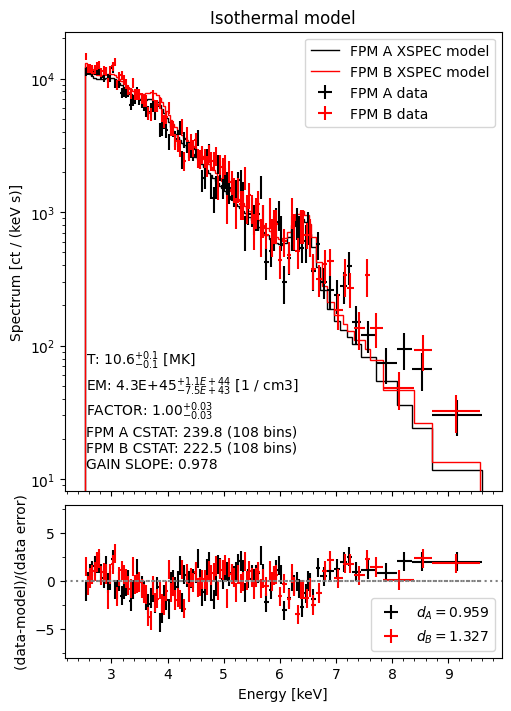

In [11]:
fig, axs = plt.subplots(
    2, 1,
    figsize=(5,7),
    sharex=True,
    layout='constrained',
    gridspec_kw=dict(height_ratios=[3,1],hspace=0)
)

plotter = ModelPlotter(archive)
ax0, ax1 = plotter.make_xspec_plot(model_name, axs=axs)
ax1.axhline(0, color='gray', ls=':')
ax0.legend()
ax1.legend()

plt.savefig(f'{out_dir}/{model_name}.png')

## Clear the data

This will remove the currently loaded data.

In [12]:
interface.clear_data()

# Isothermal with pileup

This shows the previous example but with a pileup model fit prior (and held fixed) to the data model.

**NOTE:** the response must be contained in a *single* file for this to work with PyXSPEC since we make use of the multiresponse attributes of PyXSPEC's `Spectrum` class, which only allows the specification of one response file.

In [13]:
abundance_file = '/home/reed/feld92a_coronal0.txt' # Change this
xspec.Xset.abund = f'file {abundance_file}'
interface = XSPECInterface()

data_dir = './data/'
out_dir = './output/'
fpmA_pha = 'fpmA_g0-4.pha'
fpmA_pileup = 'fpmA_g21-24.pha'
fpmB_pha = 'fpmB_g0-4.pha'
fpmB_pileup = 'fpmB_g21-24.pha'

## Read the pileup data, then set and fit the pileup model

Since we are fitting a pileup model then fixing, we specify the pileup file as the signal file.
Specifying both the signal file and pileup file at the same time indicates they will be fit simultaneously.

In [14]:
interface.add_instrument(
    name = 'FPM A',
    signal_file = fpmA_pileup
)
interface.add_instrument(
    name = 'FPM B',
    signal_file = fpmB_pileup
)
interface.read_data(data_dir)
xspec.AllData.ignore('bad') # Specify which energy channels to ignore.

component_name = 'pileup'
pileup_model = interface.add_component(
    model_name = component_name,
    expression = 'expmodgauss',
    parameter_limits_file = DEFAULT_PILEUP_PARAMETER_FILE,
    out_dir = out_dir,
    tie_data_groups = False # FPM A and FPM B will have different pileup models
)

interface.fit()
interface.archive_previous()
interface.clear_data()

Instrument: FPM A
	 {'signal_file': 'fpmA_g21-24.pha', 'signal_data_group': 1, 'signal_source': 1}
	 {}
Instrument: FPM B
	 {'signal_file': 'fpmB_g21-24.pha', 'signal_data_group': 2, 'signal_source': 1}
	 {}
1:1 fpmA_g21-24.pha 2:2 fpmB_g21-24.pha 
Adding new component pileup with expression expmodgauss
Full expression is now expmodgauss
pileup
parameter limits file: /home/reed/Documents/research/software/pyxspec_extension/config/default_pileup.xconf
setting parameter limits for group 1 component expmodgauss parameter norm (4)
(0.9955959999999999, 0.00995596, 0.0, 0.0, 9.95596e+19, 9.955959999999999e+23)

setting parameter limits for group 2 component expmodgauss parameter norm (4)
(0.9955959999999999, 0.00995596, 0.0, 0.0, 9.95596e+19, 9.955959999999999e+23)

error_str: pileup:1 pileup:2 pileup:3 pileup:4 pileup:5 pileup:6 pileup:7 pileup:8 
result component names: ['expmodgauss']
result component names: ['expmodgauss']
FPM A result:
	Key: energy_edges
	Key: energy
	Key: energy_err
	K

## Read in the signal data and set the flare model

We freeze the pileup parameters, but the pileup *component* is kept in the model.
This allows us the fit the flare data while still modeling pileup.

In [15]:
interface.clear_data()
interface.add_instrument(
    name = 'FPM A',
    signal_file = fpmA_pha
)
interface.add_instrument(
    name = 'FPM B',
    signal_file = fpmB_pha
)
interface.read_data(data_dir)
xspec.AllData.ignore('bad')

model_name = 'isothermal_with_pileup'
interface.add_component(
    model_name = model_name,
    expression = 'const*vapec',
    parameter_limits_file = DEFAULT_PARAMETER_FILE,
    out_dir = out_dir,
    freeze_previous = True # This freezes the pileup model parameters
)
interface.set_gain(
    slope = (1, 0.01, 0.94, 0.94, 1.0, 1.0),
    offset = 0,
    fit_slope = True,
    fit_offset = False
)

# Modify the pileup norm to accurately represent the grade 0-4 pileup.
for instrument in interface.instruments.values():
        model = instrument.get_signal_model(model_name)
        pileup_model = interface.archive.instruments[instrument.name]['pileup']
        pileup_model.expmodgauss.norm.values = (1.25*pileup_model.expmodgauss.norm.values[0], *pileup_model.expmodgauss.norm.values[1:])
        pileup_model.expmodgauss.norm.frozen = True

Instrument: FPM A
	 {'signal_file': 'fpmA_g0-4.pha', 'signal_data_group': 1, 'signal_source': 1}
	 {}
Instrument: FPM B
	 {'signal_file': 'fpmB_g0-4.pha', 'signal_data_group': 2, 'signal_source': 1}
	 {}
1:1 fpmA_g0-4.pha 2:2 fpmB_g0-4.pha 
result component names: ['expmodgauss']
result component names: ['expmodgauss']
newly_archived: OrderedDict([('FPM A', {'signal': <pyxspec_extension.interface.ArchivedModel object at 0x7f1e4c586390>}), ('FPM B', {'signal': <pyxspec_extension.interface.ArchivedModel object at 0x7f1e4ea2d150>})])
Archived model FPM A pileup, expression expmodgauss
	Component expmodgauss
		Parameter lam
			Values: [1.0759696630811415, 0.010759696630811414, 0.1, 0.1, 3.0, 3.0]
			Frozen: False
		Parameter mu
			Values: [3.05046818800692, 0.030504681880069204, 2.5, 2.5, 10.0, 10.0]
			Frozen: False
		Parameter sigma
			Values: [0.7884980750073016, 0.007884980750073016, 0.01, 0.01, 4.0, 4.0]
			Frozen: False
		Parameter norm
			Values: [0.5554248294183467, 0.0055542482941

## Fit and save the model

In [16]:
interface.fit(critical_delta=0.1)
interface.archive_previous()
interface.archive.save(f'{out_dir}/{model_name}_archive.pkl')

error_str: isothermal_with_pileup:6 isothermal_with_pileup:21 isothermal_with_pileup:26 


***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.
***Warning:  *** 3 point fit failed during interpolation *** 
Lower bound error calculation is invalid.
***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.
***Warning:  *** 3 point fit failed during interpolation *** 
Upper bound error calculation is invalid.
***Warning:  *** 3 point fit failed during interpola

result component names: ['expmodgauss', 'vapec']
adding component to result: expmodgauss
adding component to result: vapec
result component names: ['expmodgauss', 'vapec']
adding component to result: expmodgauss
adding component to result: vapec
FPM A result:
	Key: energy_edges
	Key: energy
	Key: energy_err
	Key: data
	Key: data_err
	Key: model
	Key: components
FPM B result:
	Key: energy_edges
	Key: energy
	Key: energy_err
	Key: data
	Key: data_err
	Key: model
	Key: components
result component names: ['expmodgauss', 'vapec']
adding component to result: expmodgauss
adding component to result: vapec
result component names: ['expmodgauss', 'vapec']
adding component to result: expmodgauss
adding component to result: vapec
newly_archived: OrderedDict([('FPM A', {'signal': <pyxspec_extension.interface.ArchivedModel object at 0x7f1e4c69f550>}), ('FPM B', {'signal': <pyxspec_extension.interface.ArchivedModel object at 0x7f1e4c4b9110>})])
Archived model FPM A isothermal_with_pileup, expression 

## Plot the results

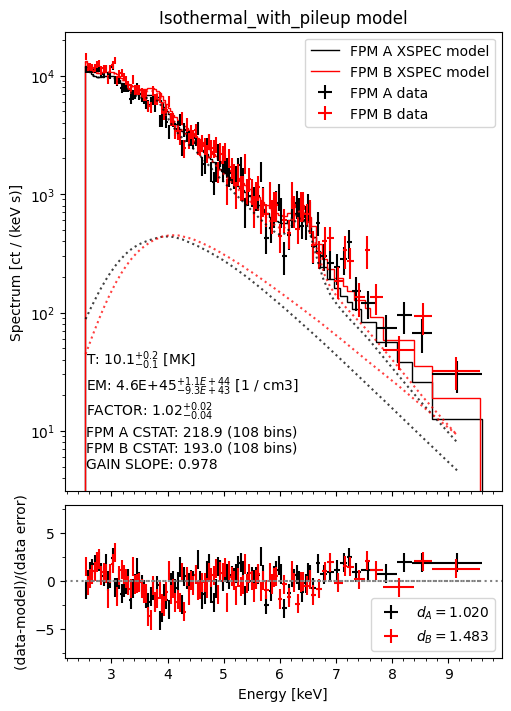

In [17]:
fig, axs = plt.subplots(
    2, 1,
    figsize=(5,7),
    sharex=True,
    layout='constrained',
    gridspec_kw=dict(height_ratios=[3,1],hspace=0)
)

plotter = ModelPlotter(interface.archive)
ax0, ax1 = plotter.make_xspec_plot(model_name, axs=axs)
ax1.axhline(0, color='gray', ls=':')
ax0.legend()
ax1.legend()

plt.savefig(f'{out_dir}/{model_name}.png')

## Print the archive

In [18]:
archive = interface.archive
for name, instrument in (archive.instruments).items():
    print(f'Instrument: {name}')
    for model_name, model in instrument.items():
        print(f'\tModel: {model_name}')
        print(f'\tModel arrays: {model.arrays._fields}')
        for component_name, component in (model.components).items():
            print(f'\t\tComponent: {component_name}')
            for parameter_name, parameter in (component.parameters).items():
                print(f'\t\t\tParameter: {parameter_name}')
                print(f'\t\t\t\t{parameter.values}')
                print(f'\t\t\t\t{parameter.error}')

Instrument: FPM A
	Model: pileup
	Model arrays: ('energy_edges', 'energy', 'energy_err', 'data', 'data_err', 'model', 'components')
		Component: expmodgauss
			Parameter: lam
				[1.0759696630811415, 0.010759696630811414, 0.1, 0.1, 3.0, 3.0]
				(0.9275615928306292, 1.2806294297058696, 'FFFFFFFFF')
			Parameter: mu
				[3.05046818800692, 0.030504681880069204, 2.5, 2.5, 10.0, 10.0]
				(2.8081236027173, 3.222764699671412, 'FFFFFFFFF')
			Parameter: sigma
				[0.7884980750073016, 0.007884980750073016, 0.01, 0.01, 4.0, 4.0]
				(0.4981113679029639, 1.080189966287635, 'FFFFFFFFF')
			Parameter: norm
				(0.6942810367729334, 0.005554248294183467, 0.0, 0.0, 9.95596e+19, 9.955959999999999e+23)
				(0.4949405060347688, 0.6443543955442244, 'FFFFFFFFF')
	Model: isothermal_with_pileup
	Model arrays: ('energy_edges', 'energy', 'energy_err', 'data', 'data_err', 'model', 'components')
		Component: expmodgauss
			Parameter: lam
				[1.0759696630811415, -0.010759696630811414, 0.1, 0.1, 3.0, 3.0]
				(